# 1. Setup Environment and Configuration
This notebook loads MMSFM image checkpoints, regenerates trajectories, and produces diagnostic plots. Update `RESULT_DIR` in the next cell to match the run you want to inspect.

In [10]:
import ast
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import torch
from IPython.display import Image, display
from matplotlib.animation import FuncAnimation, PillowWriter
from torchvision.utils import make_grid

import wandb

# ensure project root is importable
PROJECT_ROOT = Path.cwd().parent.resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
    

from scripts.images.images_utils import load_data, get_hypers, build_models
from scripts.images.images_eval import traj_gen
from scripts.images.grf_data import load_grf_dataset
from scripts.images.field_visualization import (
    format_for_paper,
    plot_field_snapshots,
    plot_field_evolution_gif,
    plot_field_statistics,
    plot_spatial_correlation,
    plot_sample_comparison_grid,
    plot_eigenvalue_spectra_comparison,
    plot_covariance_heatmaps_comparison,
    plot_vector_field_2d_projection,
    plot_vector_field_streamplot,
    plot_interpolated_probability_paths,
)

torch.manual_seed(0)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BASE_DIR = PROJECT_ROOT
# RESULT_DIR = BASE_DIR / "results" / "results/grf"
RESULT_DIR = BASE_DIR / "results" / "results/grf_sigmasmall"
ARTIFACT_DIR = RESULT_DIR / "notebook_artifacts"
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

# Apply paper-style formatting for all visualizations
format_for_paper()

print(f"Using device: {DEVICE}")
print(f"Results directory: {RESULT_DIR}")
print(f"Artifacts will be stored in: {ARTIFACT_DIR}")


def save_image_grid(tensor: torch.Tensor, name: str, scale: int = 4) -> Path:
    tensor = tensor.detach().cpu()
    n, t, c, h, w = tensor.shape
    grid = make_grid(tensor.view(n * t, c, h, w), nrow=t)
    grid = grid / 2 + 0.5
    npimg = grid.numpy().transpose(1, 2, 0)
    if npimg.shape[2] == 1:
        npimg = cm.viridis(npimg[..., 0])[..., :3]
    fig, ax = plt.subplots(figsize=(scale * t, scale * n))
    ax.imshow(npimg)
    ax.axis("off")
    png_path = ARTIFACT_DIR / f"{name}.png"
    fig.savefig(png_path, bbox_inches="tight", dpi=150)
    plt.close(fig)
    display(Image(filename=str(png_path)))
    return png_path


def save_snapshot_gif(tensor: torch.Tensor, name: str, scale: int = 4, fps: int = 5) -> Path:
    tensor = tensor.detach().cpu()
    n, t, c, h, w = tensor.shape
    fig, ax = plt.subplots(figsize=(scale * n, scale))
    times = np.linspace(0.0, 1.0, t)

    def animate(idx: int):
        ax.clear()
        grid = make_grid(tensor[:, idx], nrow=n)
        grid = grid / 2 + 0.5
        npimg = grid.numpy().transpose(1, 2, 0)
        if npimg.shape[2] == 1:
            npimg = cm.viridis(npimg[..., 0])[..., :3]
        ax.imshow(npimg)
        ax.axis("off")
        ax.text(
            0.02,
            0.95,
            f"t = {times[idx]:.2f}",
            transform=ax.transAxes,
            fontsize=12,
            color="white",
            bbox={"facecolor": "black", "alpha": 0.5, "pad": 3},
        )
        return []

    anim = FuncAnimation(fig, animate, frames=t, interval=max(50, int(1000 / fps)))
    gif_path = ARTIFACT_DIR / f"{name}.gif"
    anim.save(gif_path, writer=PillowWriter(fps=fps))
    plt.close(fig)
    display(Image(filename=str(gif_path)))
    return gif_path


Using device: cuda
Results directory: /data1/jy384/research/MMSFM/results/results/grf_sigmasmall
Artifacts will be stored in: /data1/jy384/research/MMSFM/results/results/grf_sigmasmall/notebook_artifacts


<VSCode.Cell language="markdown">
# 2. Load Checkpoints and Metadata
Parse the stored training arguments, rebuild the MMSFM models, and load the evaluation dataset split referenced by the run.

In [11]:
from typing import Any, Dict, List


def parse_args_file(args_path: Path) -> Dict[str, Any]:
    if not args_path.exists():
        raise FileNotFoundError(f"Args file not found at {args_path}")
    parsed: Dict[str, Any] = {}
    for line in args_path.read_text().splitlines():
        if "=" not in line:
            continue
        key, value = line.split("=", 1)
        key = key.strip()
        value = value.strip()
        try:
            parsed[key] = ast.literal_eval(value)
        except Exception:
            parsed[key] = value
    return parsed


def ensure_state_dict(module: torch.nn.Module, state: Any) -> None:
    if isinstance(state, dict) and "model_state_dict" in state:
        module.load_state_dict(state["model_state_dict"])
    else:
        module.load_state_dict(state)


def bool_from_config(cfg: Dict[str, Any], key: str, default: bool = False) -> bool:
    if key not in cfg:
        return default
    value = cfg[key]
    if isinstance(value, bool):
        return value
    if isinstance(value, (int, float)):
        return bool(value)
    if isinstance(value, str):
        return value.lower() in {"1", "true", "yes", "y", "on"}
    return default


args_txt = RESULT_DIR / "args.txt"
config = parse_args_file(args_txt)

size = int(config.get("size", 32))
dataname = str(config.get("dataname", "grf")).lower()
progression: List[int] = [int(idx) for idx in config.get("progression", [])]
sm_enabled = bool_from_config(config, "sm", bool_from_config(config, "score_matching", False))
sigma = float(config.get("sigma", 0.15))
n_infer = int(config.get("n_infer", 10))
t_infer = int(config.get("t_infer", 9))

if dataname == "grf":
    # Resolve GRF dataset path relative to BASE_DIR if provided as a relative path
    grf_path_cfg = config.get("grf_path", BASE_DIR / "data/mm_data.npz")
    grf_path = grf_path_cfg if isinstance(grf_path_cfg, Path) else Path(grf_path_cfg)
    if not grf_path.is_absolute():
        grf_path = BASE_DIR / grf_path
    if not grf_path.exists():
        raise FileNotFoundError(f"GRF dataset not found: {grf_path}")

    dataset = load_grf_dataset(
        grf_path,
        test_size=float(config.get("grf_test_size", 0.2)),
        seed=int(config.get("grf_seed", 42)),
        normalise=bool_from_config(config, "grf_normalise", True),
    )
    trainset = dataset.trainset
    testset = dataset.testset
    dims = dataset.dims
    grf_metadata = dataset.metadata
    grf_test_fields = [m.clone() for m in dataset.testset]
    zt_values = np.array(dataset.metadata.get("times", []), dtype=float)
else:
    # Ensure any dataset paths in config are resolved relative to BASE_DIR
    data_kwargs: Dict[str, Any] = {}
    for key in ("data_root", "root", "data_path", "path"):
        if key in config:
            p = config[key]
            p = p if isinstance(p, Path) else Path(p)
            if not p.is_absolute():
                p = BASE_DIR / p
            data_kwargs[key] = p
    trainset, testset, classes, dims = load_data(dataname, size, **data_kwargs)  # type: ignore[arg-type]
    grf_metadata = None
    grf_test_fields = None
    zt_values = np.array(config.get("zt", []), dtype=float)

if not progression:
    progression = list(range(len(testset)))

zt = np.array(config.get("zt", np.linspace(0.0, 1.0, len(progression))), dtype=float)
if zt.size == 0:
    zt = np.linspace(0.0, 1.0, len(progression))

if zt_values.size == 0:
    zt_values = zt

n_infer = min(n_infer, testset[progression[0]].shape[0])

hypers = get_hypers(dataname, size, dims)
flow_model, score_model = build_models(hypers, sm_enabled, DEVICE)

flow_state_path = RESULT_DIR / "flow_model.pth"
if not flow_state_path.exists():
    raise FileNotFoundError(f"Flow checkpoint missing at {flow_state_path}")
flow_state = torch.load(flow_state_path, map_location=DEVICE)
ensure_state_dict(flow_model, flow_state)
flow_model.eval()

if sm_enabled:
    score_state_path = RESULT_DIR / "score_model.pth"
    if not score_state_path.exists():
        raise FileNotFoundError("Score checkpoint requested but not found.")
    score_state = torch.load(score_state_path, map_location=DEVICE)
    ensure_state_dict(score_model, score_state)  # type: ignore[arg-type]
    score_model = score_model.eval()  # type: ignore[assignment]
else:
    score_model = None

progression_tensors = [testset[idx].clone() for idx in progression]
print(f"Loaded dataname='{dataname}' with dims={dims}, progression={progression}")
print(f"n_infer={n_infer}, t_infer={t_infer}, sigma={sigma}, score_matching={sm_enabled}")


def denormalise_grf(tensor: torch.Tensor) -> torch.Tensor:
    if grf_metadata is None or not grf_metadata.get("normalise", False):
        return tensor.clone()
    train_min = grf_metadata["train_min"].to(tensor.device, tensor.dtype)
    train_max = grf_metadata["train_max"].to(tensor.device, tensor.dtype)
    scale = torch.clamp(train_max - train_min, min=1e-6)
    return ((tensor + 1.0) * 0.5) * scale + train_min

Loaded dataname='grf' with dims=torch.Size([1, 32, 32]), progression=[0, 1, 2, 3, 4]
n_infer=10, t_infer=9, sigma=0.01, score_matching=True


# 3. Generate Deterministic Trajectories
Run the learned flow field as an ODE to reproduce forward trajectories and store the results for later analysis.

In [12]:
x0 = progression_tensors[0][:n_infer].to(DEVICE)
xT = progression_tensors[-1][:n_infer].to(DEVICE)

ode_np, _ = traj_gen(
    None,
    x0,
    xT,
    flow_model,
    score_model if sm_enabled else None,
    dims,
    n_infer,
    t_infer,
    sigma,
    False,
    device=DEVICE,
)

torch_ode = (
    torch.from_numpy(ode_np)
    .view(t_infer, n_infer, *dims)
    .transpose(0, 1)
    .contiguous()
)
ode_path = ARTIFACT_DIR / "torch_ode_trajs_nb.pt"
torch.save(torch_ode, ode_path)
print(f"Saved forward trajectories to {ode_path.relative_to(BASE_DIR)}")

torch_ode.shape

Solving forward ODE and computing trajectories...
Forward ODESolve took 0.06s
Saved forward trajectories to results/results/grf_sigmasmall/notebook_artifacts/torch_ode_trajs_nb.pt


/home/jy384/miniconda3/envs/3MASB/lib/python3.13/site-packages/torchdyn/numerics/odeint.py:83: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


torch.Size([10, 9, 1, 32, 32])

<VSCode.Cell language="markdown">
# 4. Generate Stochastic Trajectories
When a score network is available, integrate the backward SDE to produce stochastic trajectories that mirror `torch_sde_trajs.pt`.

In [13]:

if score_model is None:
    print("Score model unavailable; skipping stochastic sampling.")
    torch_sde = None
else:
    _, sde_np = traj_gen(
        None,
        x0,
        xT,
        flow_model,
        score_model,
        dims,
        n_infer,
        t_infer,
        sigma,
        True,
        device=DEVICE,
    )
    torch_sde = (
        torch.from_numpy(sde_np)
        .view(t_infer, n_infer, *dims)
        .transpose(0, 1)
        .contiguous()
    )
    sde_path = ARTIFACT_DIR / "torch_sde_trajs_nb.pt"
    torch.save(torch_sde, sde_path)
    print(f"Saved stochastic trajectories to {sde_path.relative_to(BASE_DIR)}")

torch_sde.shape if torch_sde is not None else None

Solving forward ODE and computing trajectories...
Forward ODESolve took 0.07s
Solving backward SDE and computing trajectories...
Backward SDESolve took 150.67s
Saved stochastic trajectories to results/results/grf_sigmasmall/notebook_artifacts/torch_sde_trajs_nb.pt


torch.Size([10, 9, 1, 32, 32])

# 5. Visualize Image Trajectories
Render snapshot grids and animated timelines for the generated image trajectories.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10977936..1.1243651].


Forward ODE trajectory visualizations


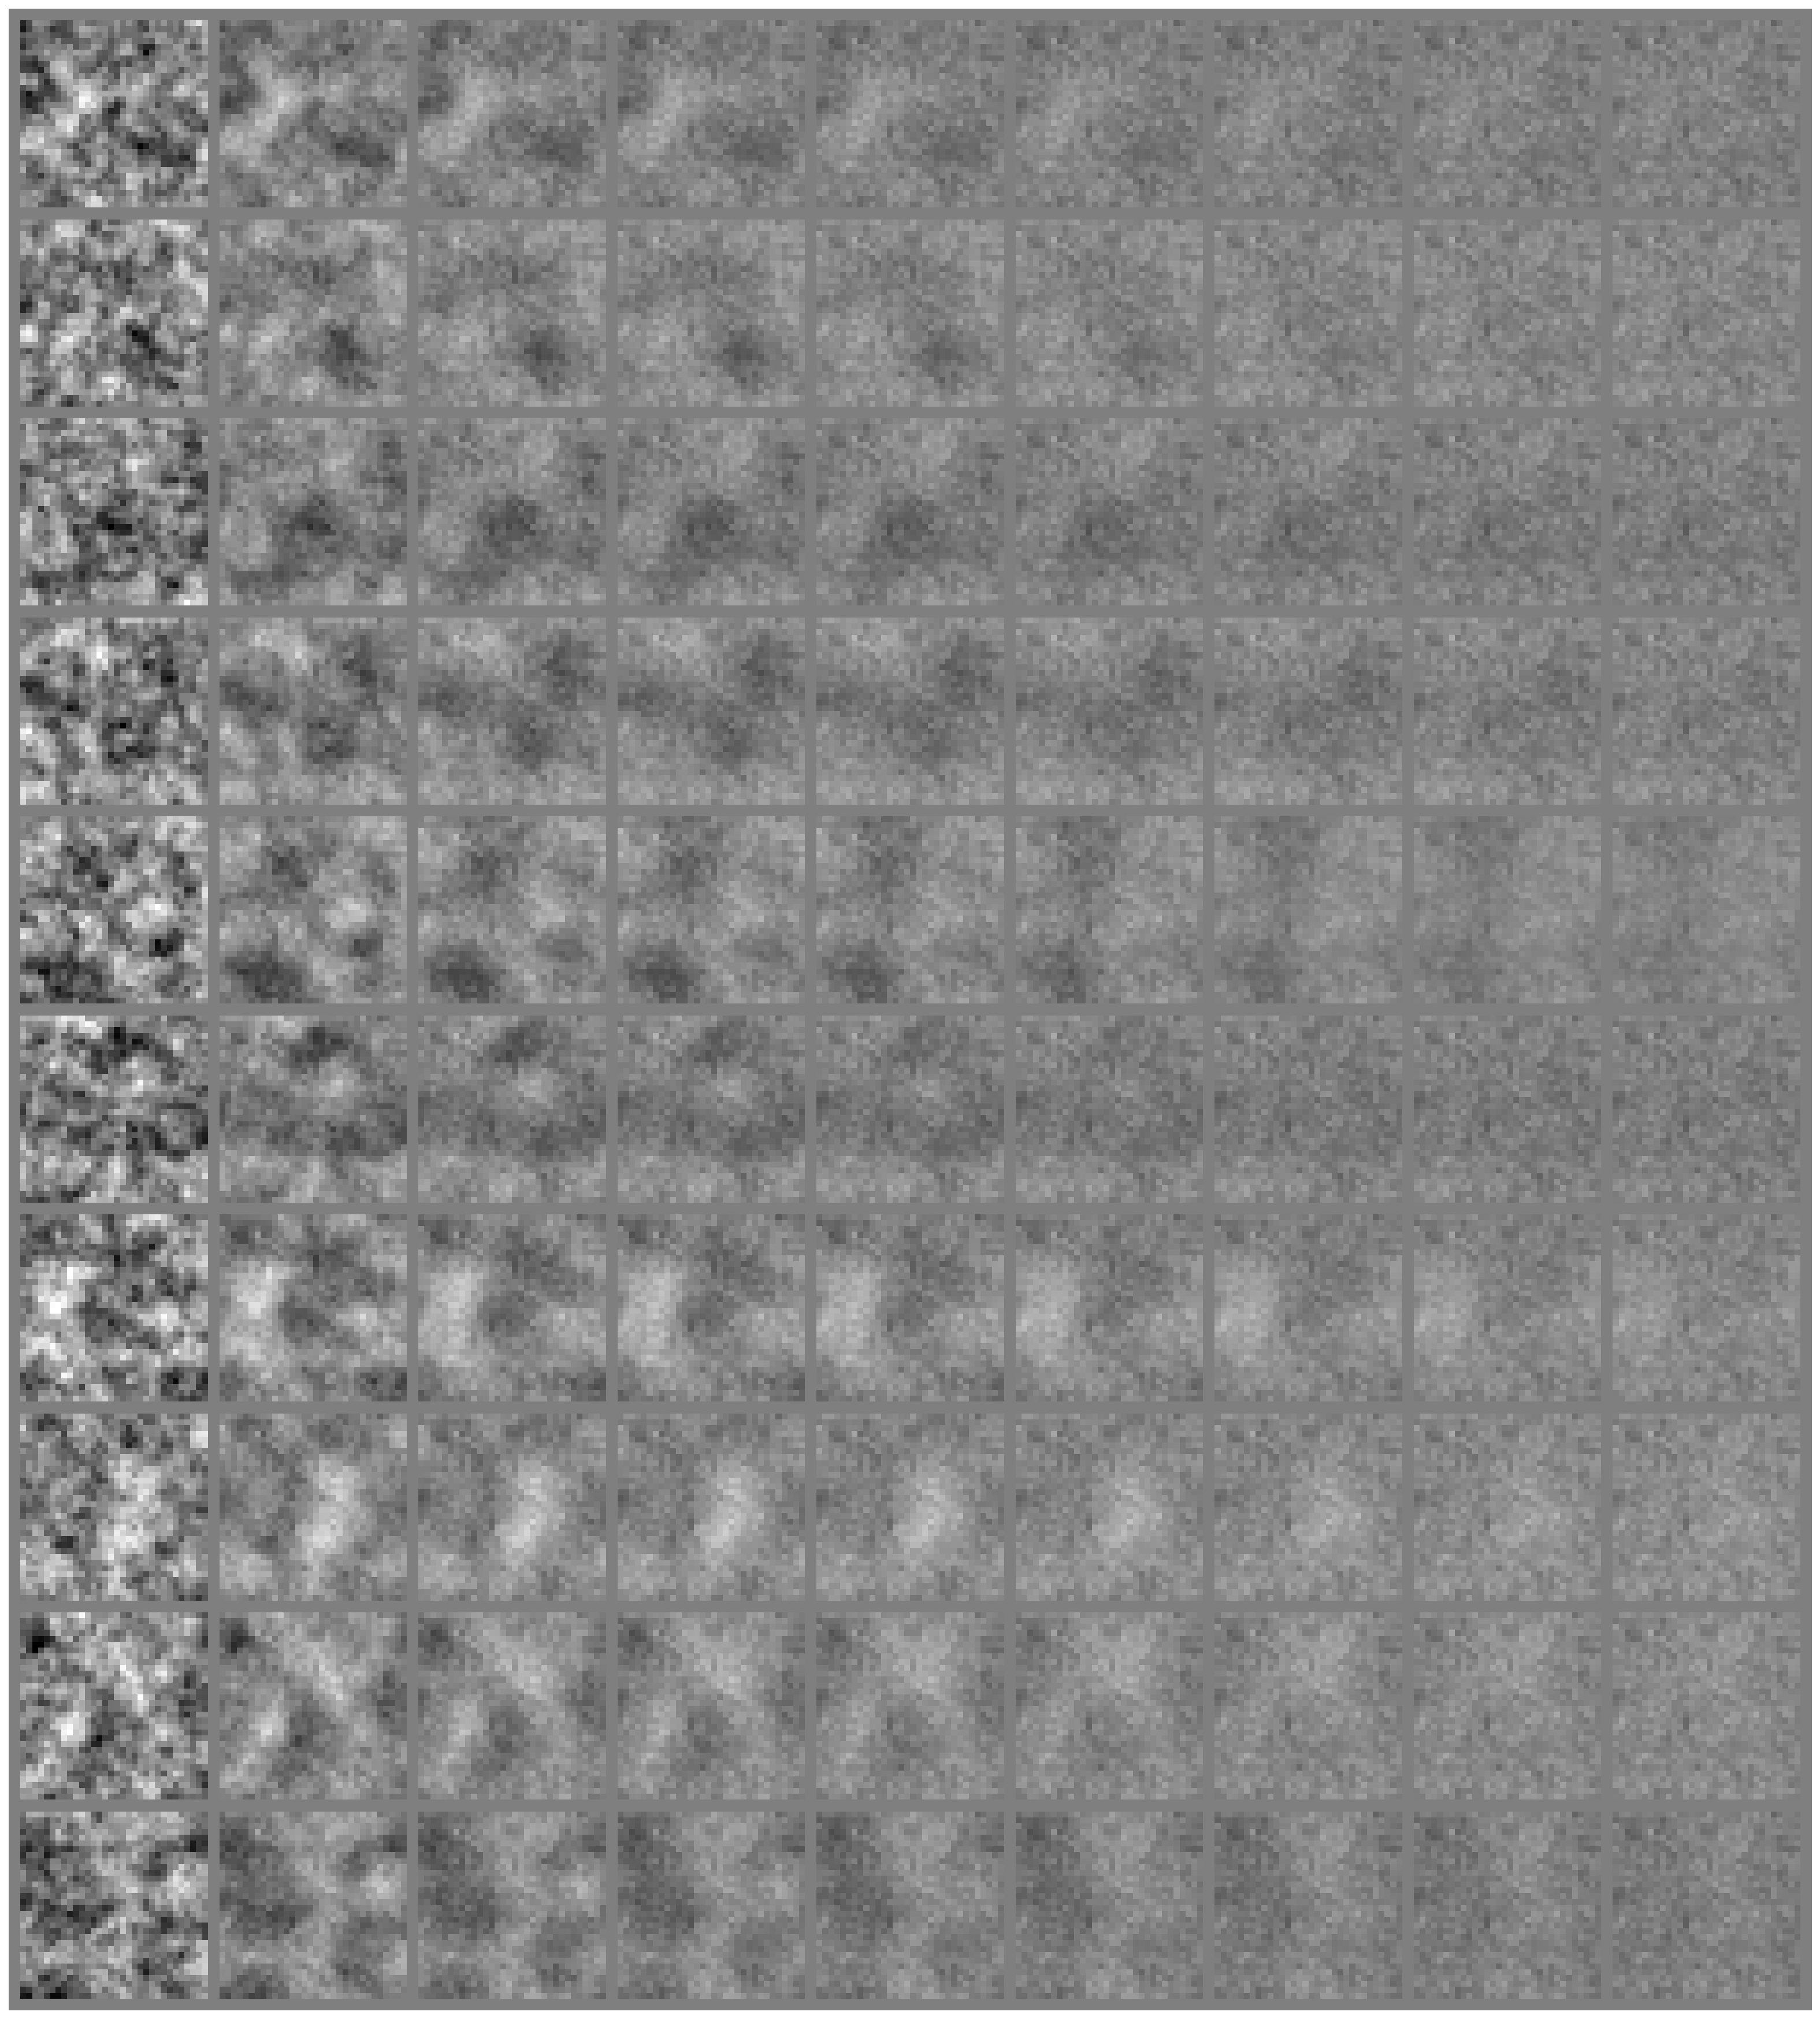

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10977936..1.1243651].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10977936..1.1243651].


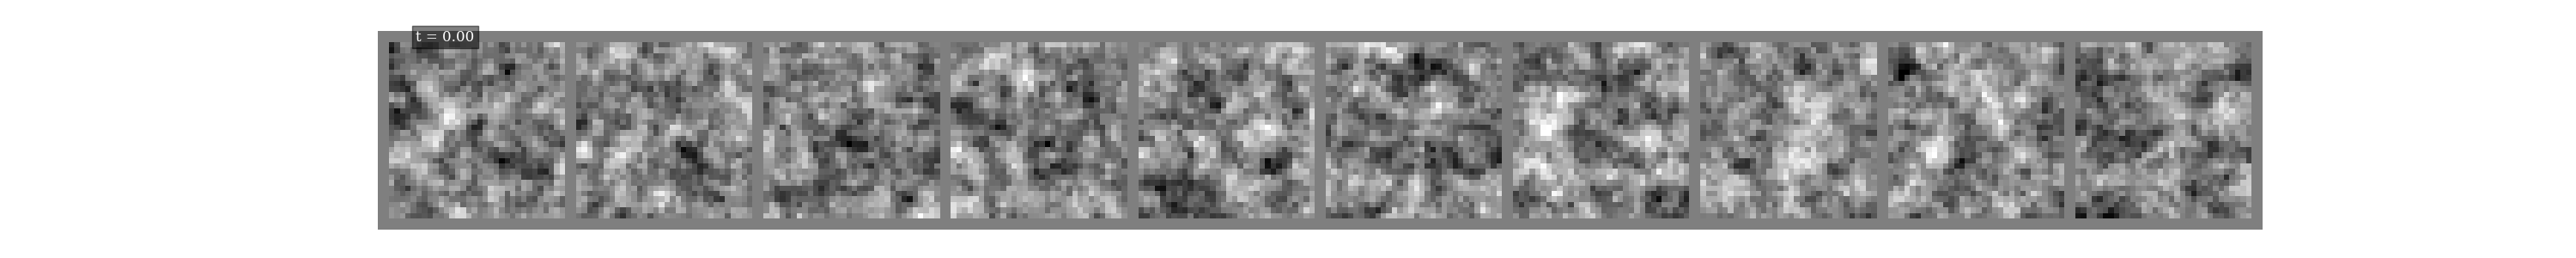

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6657443..1.6072861].


Stochastic SDE trajectory visualizations


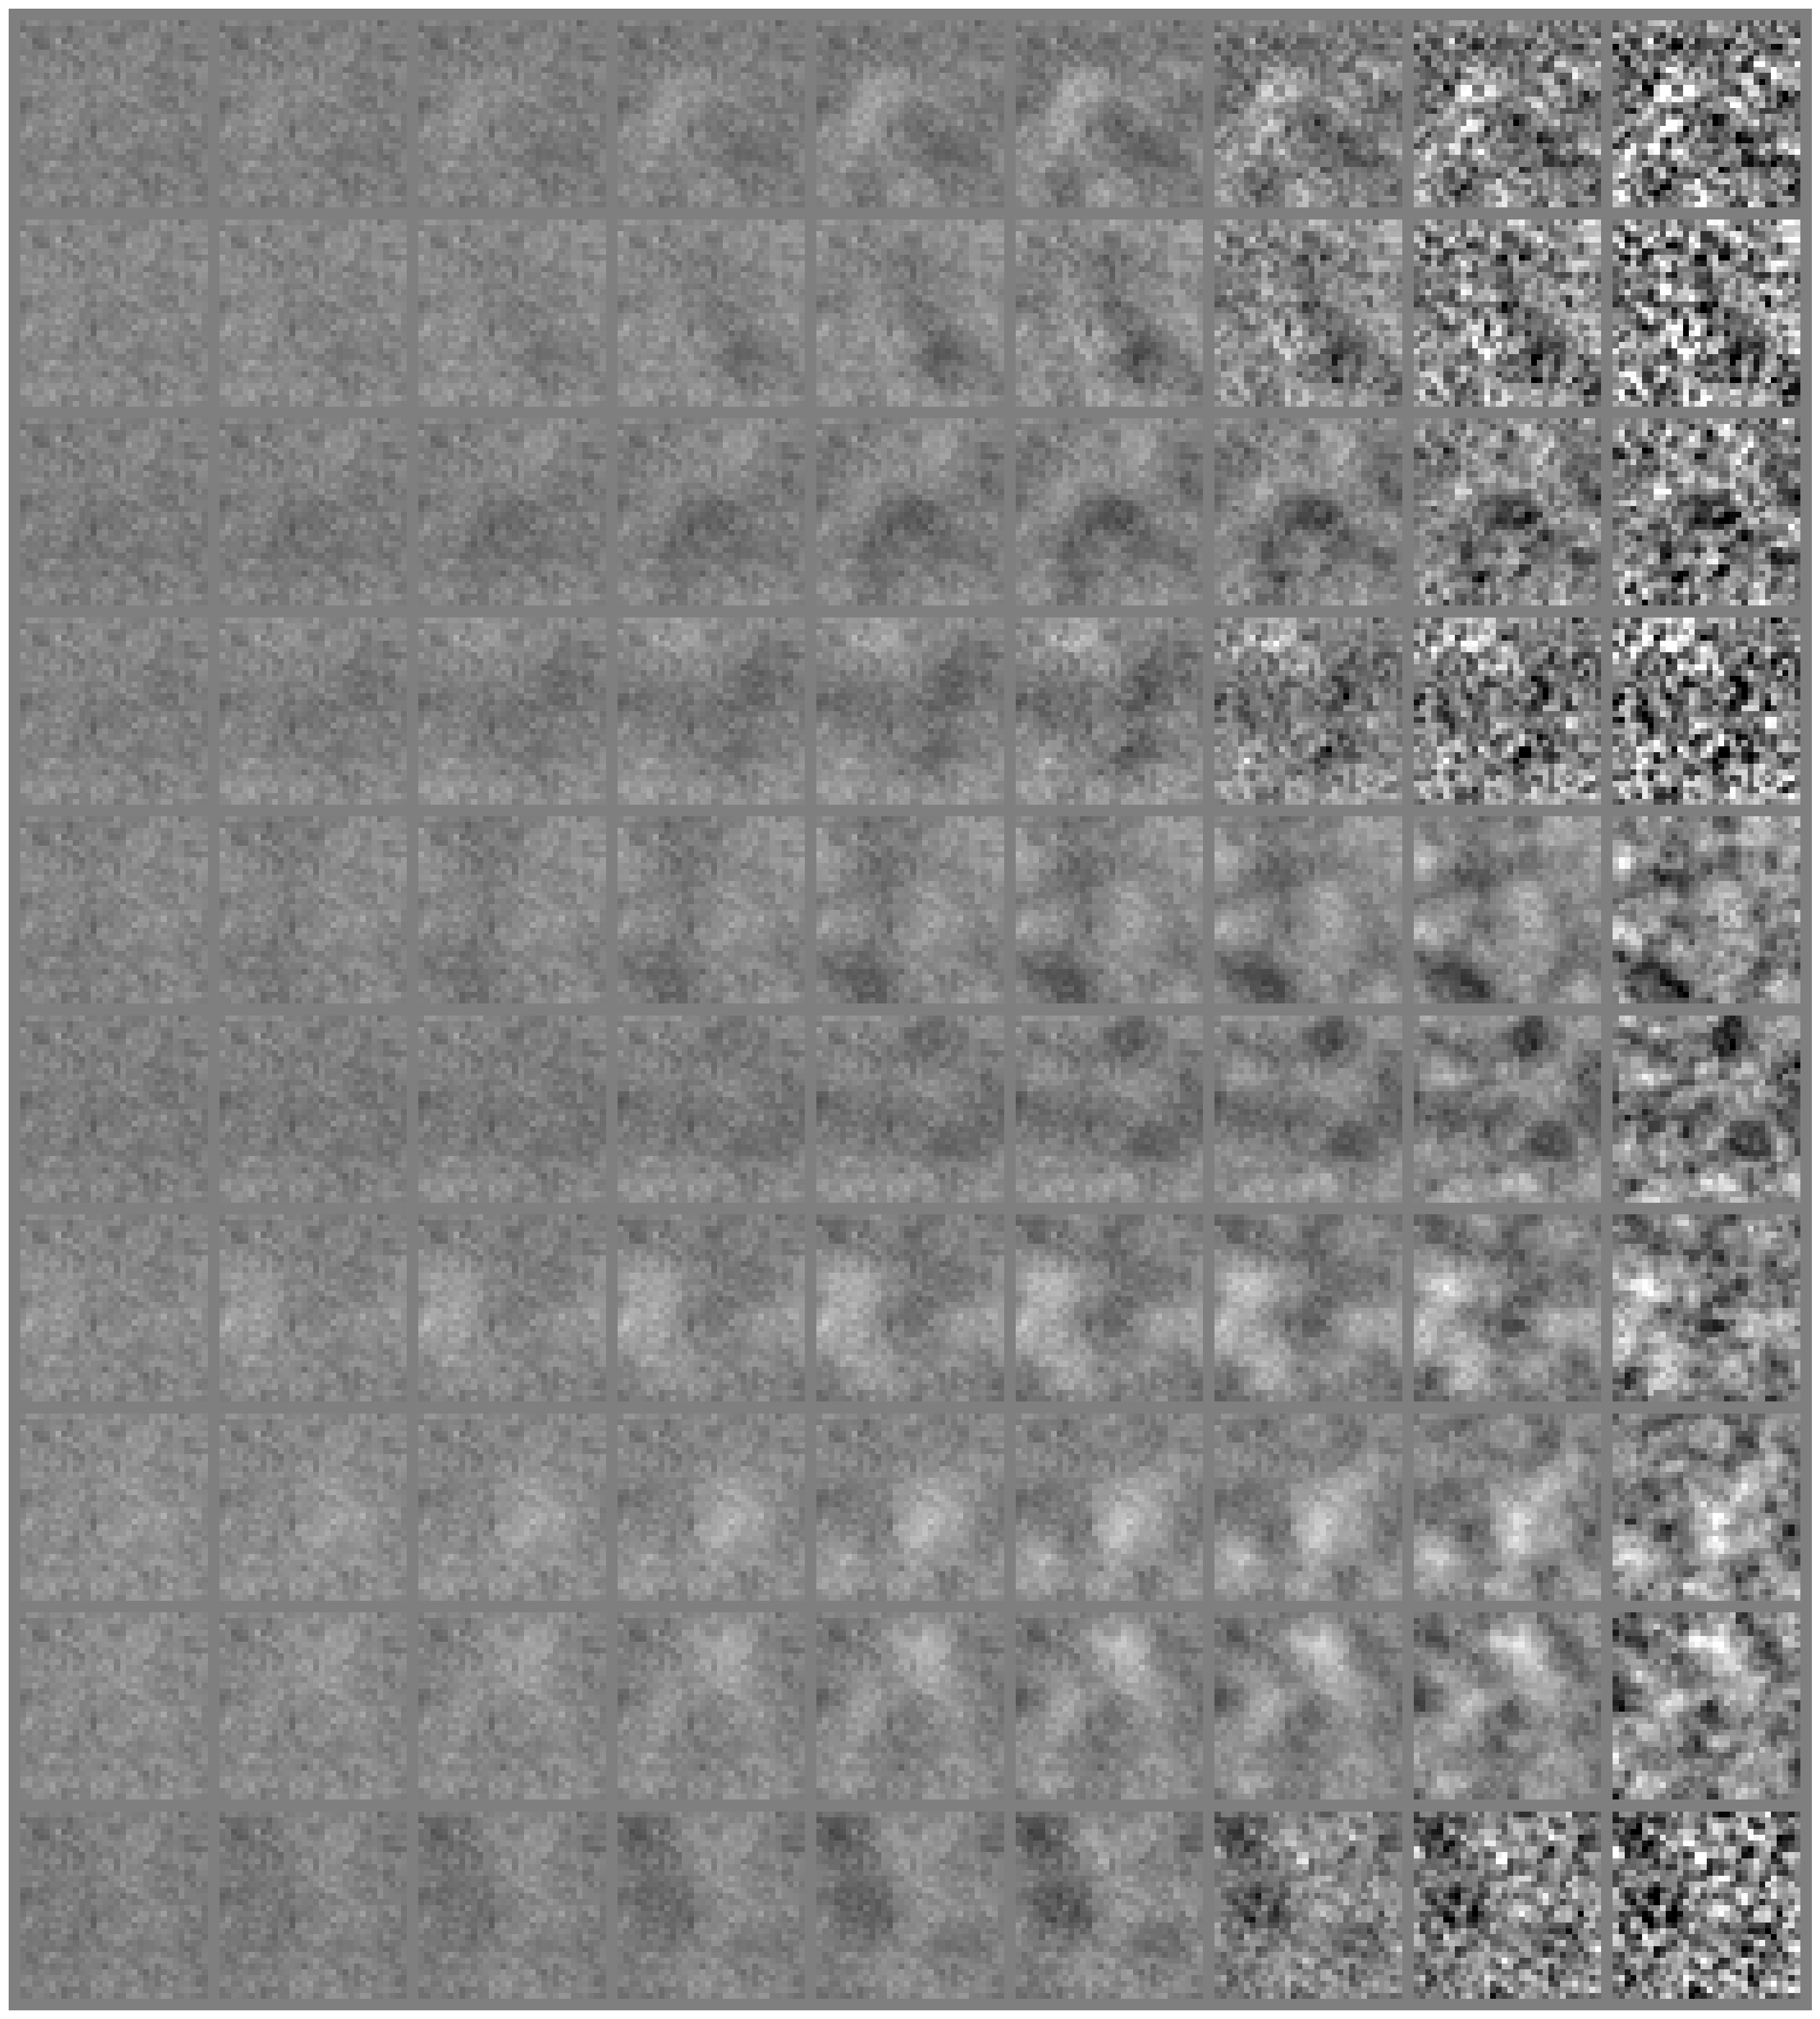

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3265559..1.2866333].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6657443..1.6072861].


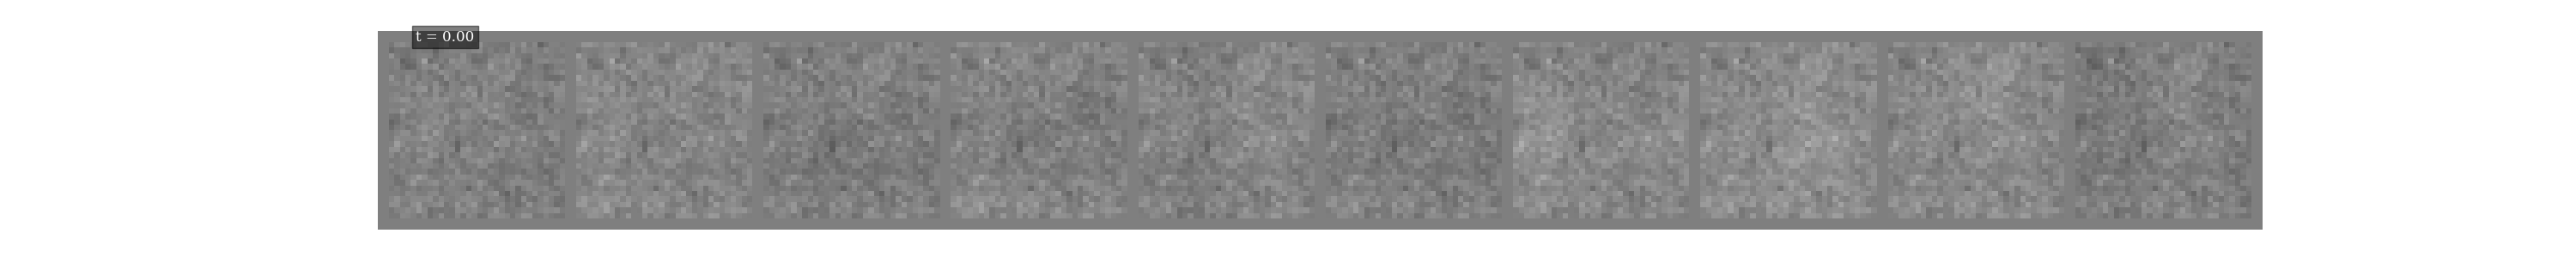

In [14]:
print("Forward ODE trajectory visualizations")
_ = save_image_grid(torch_ode, "ode_trajs_grid", scale=3)
_ = save_snapshot_gif(torch_ode, "ode_trajs_snapshots", scale=3, fps=5)

if torch_sde is not None:
    print("Stochastic SDE trajectory visualizations")
    _ = save_image_grid(torch_sde, "sde_trajs_grid", scale=3)
    _ = save_snapshot_gif(torch_sde, "sde_trajs_snapshots", scale=3, fps=5)
else:
    print("Skipping SDE visualizations (score model disabled).")

# 6. Visualize GRF Field Diagnostics
For GRF experiments, convert the trajectories back into scalar fields and reproduce PCA-style diagnostics.

GRF diagnostics for ODE trajectories (BACKWARD generation)
Note: Ground truth is time-reversed to match backward trajectory direction


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.



Performing covariance analysis for ODE trajectories...


ODE covariance analysis complete!

GRF diagnostics for SDE trajectories (BACKWARD generation)
Note: Ground truth is time-reversed to match backward trajectory direction


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


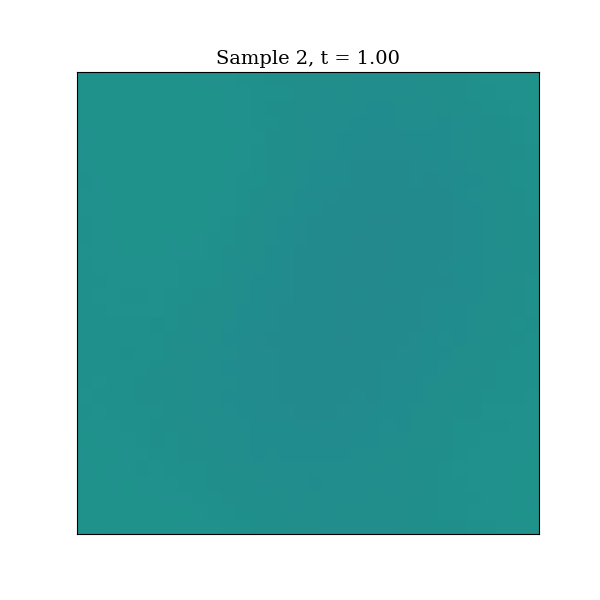

MovieWriter imagemagick unavailable; using Pillow instead.


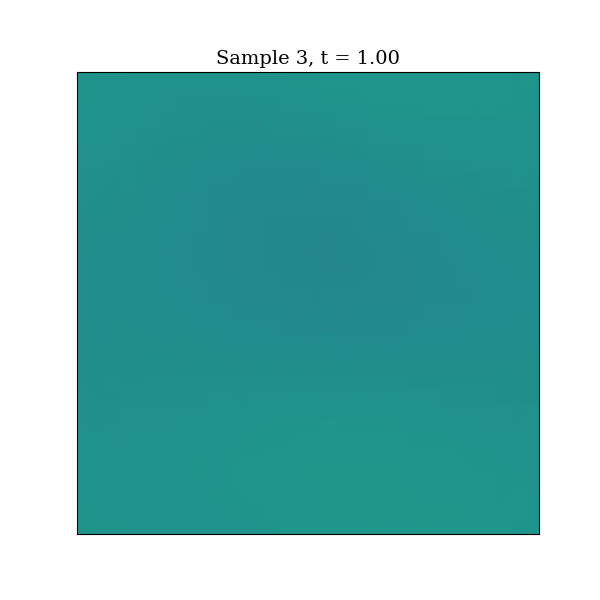

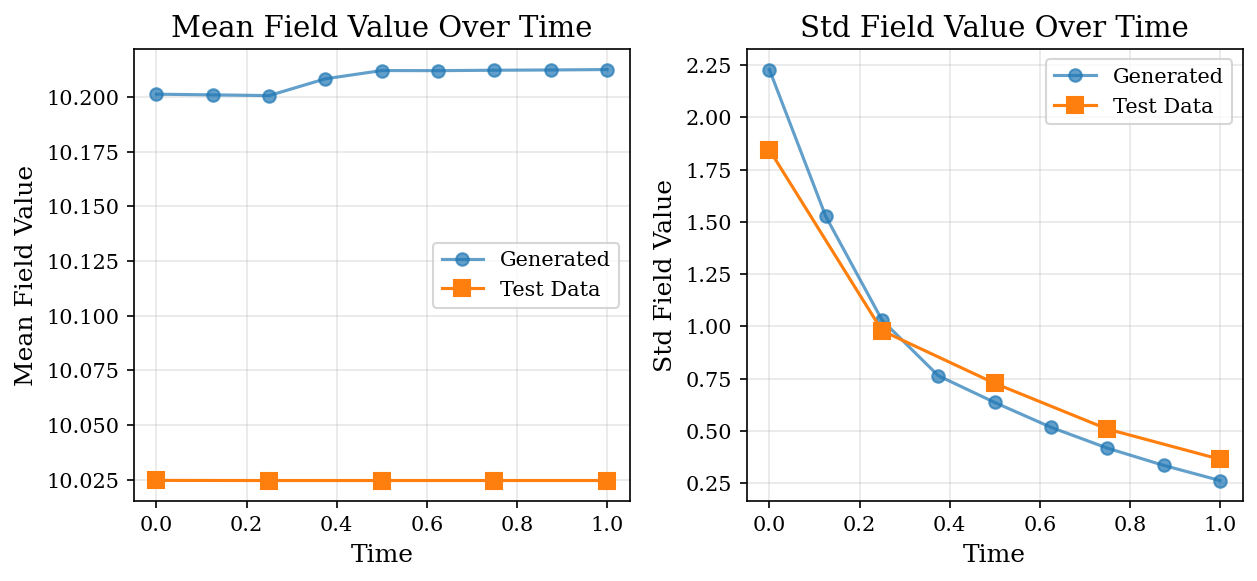

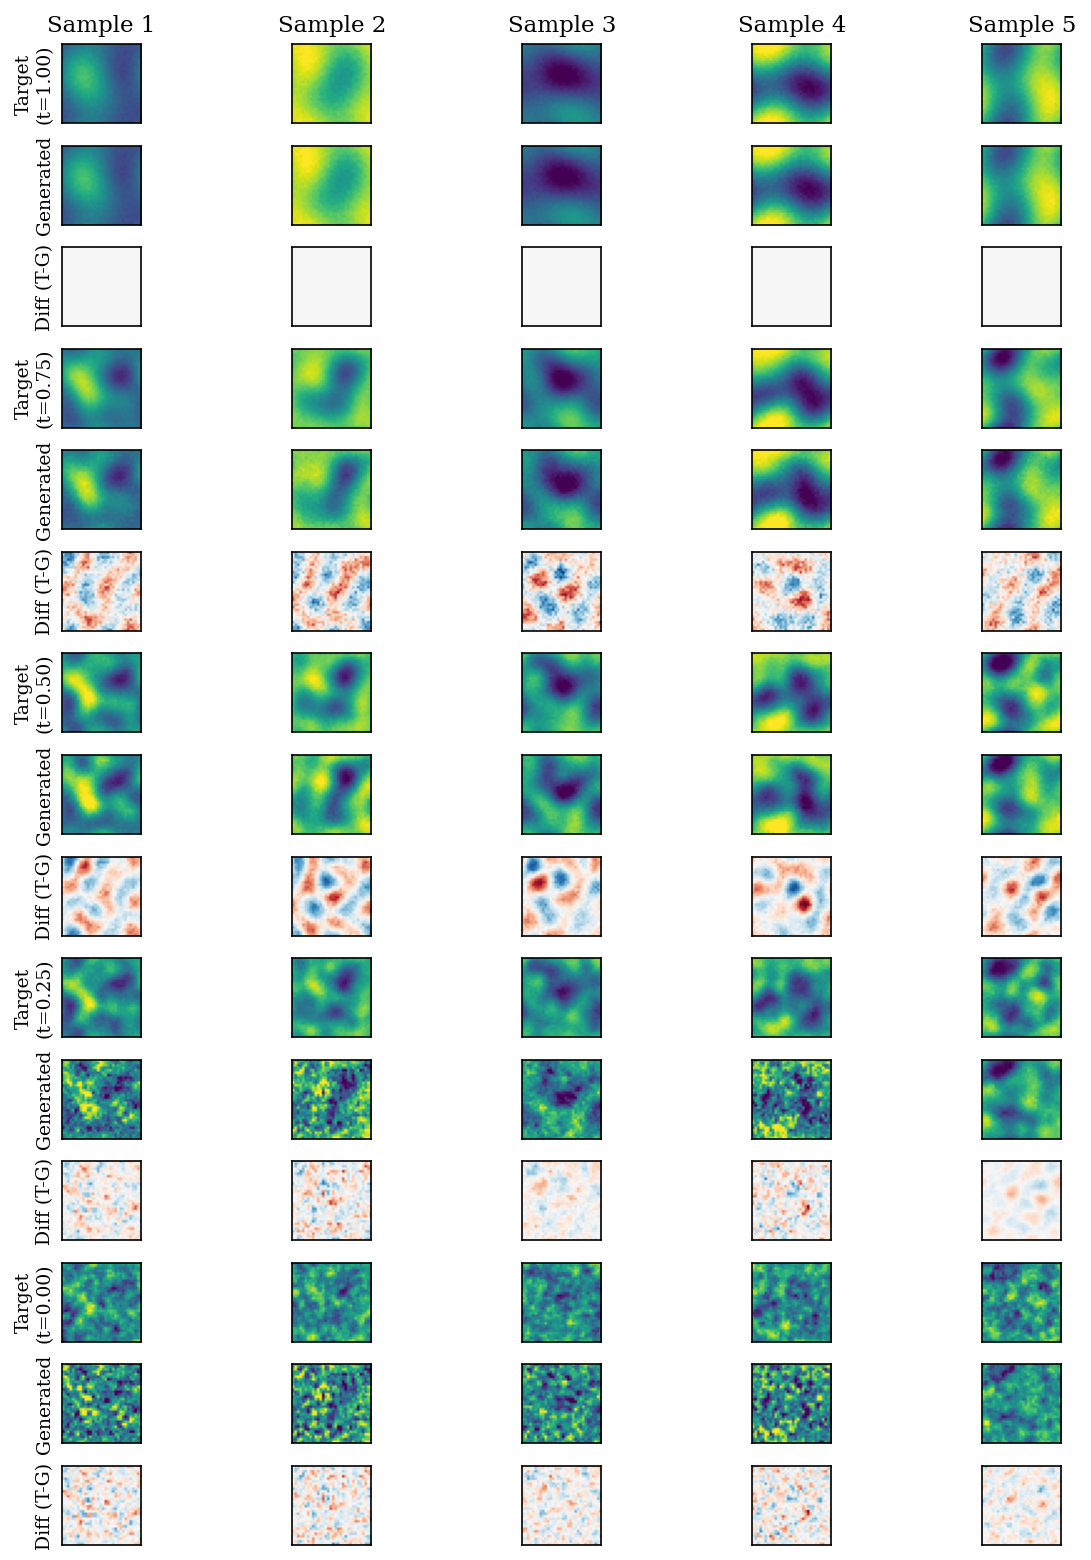


Performing covariance analysis for SDE trajectories...
SDE covariance analysis complete!

All GRF field diagnostics complete!


In [15]:
if grf_metadata is None:
    print("Non-GRF dataset detected; skipping field diagnostics.")
else:
    class NotebookRun:
        def log(self, data):
            return None

    def tensor_to_fields(traj: torch.Tensor) -> np.ndarray:
        """Convert trajectory tensor to field array format (T, N, H, W)."""
        denorm = denormalise_grf(traj)
        array = denorm.detach().cpu().numpy()
        array = array.squeeze(2)
        return array.transpose(1, 0, 2, 3)

    def prepare_test_fields() -> list[np.ndarray]:
        """Prepare ground-truth test fields for comparison (forward time order)."""
        if grf_test_fields is None:
            return []
        arrays = []
        for marginal in grf_test_fields:
            denorm = denormalise_grf(marginal)
            arrays.append(denorm.squeeze(1).cpu().numpy())
        return arrays

    def fields_to_covariance_dict(fields: np.ndarray, time_values: np.ndarray) -> dict[float, torch.Tensor]:
        """Convert field array (T, N, H, W) to time-indexed dict of flattened samples."""
        T, N, H, W = fields.shape
        result = {}
        for t_idx, t_val in enumerate(time_values):
            if t_idx < T:
                # Flatten spatial dimensions: (N, H*W)
                flat_samples = fields[t_idx].reshape(N, -1)
                result[float(t_val)] = torch.from_numpy(flat_samples).float()
        return result

    def display_artifact(relative_path: str) -> None:
        """Display a saved artifact image inline."""
        artifact_path = ARTIFACT_DIR / relative_path
        if artifact_path.exists():
            display(Image(filename=str(artifact_path)))
        else:
            print(f"Artifact missing: {artifact_path}")

    outdir = str(ARTIFACT_DIR)
    local_run = NotebookRun()
    
    # Prepare ground truth in both forward and backward (reversed) time order
    test_fields_forward = prepare_test_fields()
    test_fields_backward = list(reversed(test_fields_forward)) if test_fields_forward else []
    zt_values_reversed = zt_values[::-1].copy()  # Reversed time values for backward trajectories

    # ========== ODE Trajectory Diagnostics ==========
    ode_fields = tensor_to_fields(torch_ode)
    print("=" * 70)
    print("GRF diagnostics for ODE trajectories (BACKWARD generation)")
    print("Note: Ground truth is time-reversed to match backward trajectory direction")
    print("=" * 70)
    
    # Use reversed ground truth for backward-generated ODE trajectories
    plot_field_snapshots(ode_fields, zt_values_reversed, outdir, local_run, n_samples=min(5, ode_fields.shape[1]), score=False)
    # display_artifact("field_snapshots_ode.png")
    
    plot_field_evolution_gif(ode_fields, zt_values_reversed, outdir, local_run, sample_idx=0, score=False, fps=5)
    # display_artifact("field_evolution_ode_sample0.gif")
    for extra_idx in (1, 2):
        if extra_idx < ode_fields.shape[1]:
            plot_field_evolution_gif(ode_fields, zt_values_reversed, outdir, local_run, sample_idx=extra_idx, score=False, fps=5)
            # display_artifact(f"field_evolution_ode_sample{extra_idx}.gif")
    
    if test_fields_backward:
        plot_field_statistics(ode_fields, zt_values_reversed, test_fields_backward, outdir, local_run, score=False)
        # display_artifact("field_statistics_ode.png")
        
        plot_sample_comparison_grid(test_fields_backward, ode_fields, zt_values_reversed, outdir, local_run, score=False, n_samples=5)
        # display_artifact("field_sample_comparison_ode.png")
    
    plot_spatial_correlation(ode_fields, zt_values_reversed, outdir, local_run, score=False)
    # display_artifact("spatial_correlation_ode.png")

    # ========== ODE Covariance Analysis ==========
    if test_fields_backward:
        print("\nPerforming covariance analysis for ODE trajectories...")
        
        # Prepare ground-truth covariance dictionary (using REVERSED/backward time alignment)
        target_cov_dict_backward = {}
        for idx, t_val in enumerate(zt_values_reversed):
            if idx < len(test_fields_backward):
                flat_backward = test_fields_backward[idx].reshape(test_fields_backward[idx].shape[0], -1)
                target_cov_dict_backward[float(t_val)] = torch.from_numpy(flat_backward).float()
        
        # Prepare generated covariance dictionary (using reversed time values)
        gen_cov_dict = fields_to_covariance_dict(ode_fields, zt_values_reversed)
        
        # Select time points for covariance comparison (up to 5 evenly spaced)
        num_cov_times = min(5, len(zt_values_reversed))
        cov_time_indices = np.linspace(0, len(zt_values_reversed) - 1, num_cov_times).astype(int)
        cov_time_points = [zt_values_reversed[i] for i in cov_time_indices]
        
        # Plot eigenvalue spectra comparison (backward-aligned)
        plot_eigenvalue_spectra_comparison(
            target_cov_dict_backward,
            gen_cov_dict,
            cov_time_points,
            variance_threshold=0.999,
            outdir=outdir,
            run=local_run,
            score=False,
        )
        # display_artifact("covariance_diagnostics_ode_eigenvalues.png")
        # display_artifact("covariance_diagnostics_ode_cumulative_variance.png")
        
        # Plot truncated covariance heatmaps (backward-aligned)
        plot_covariance_heatmaps_comparison(
            target_cov_dict_backward,
            gen_cov_dict,
            cov_time_points,
            max_dim_for_heatmap=32,
            variance_threshold=0.999,
            outdir=outdir,
            run=local_run,
            score=False,
        )
        # display_artifact("truncated_covariance_ode.png")
        print("ODE covariance analysis complete!")

    # ========== SDE Trajectory Diagnostics ==========
    if torch_sde is not None:
        sde_fields = tensor_to_fields(torch_sde)
        print("\n" + "=" * 70)
        print("GRF diagnostics for SDE trajectories (BACKWARD generation)")
        print("Note: Ground truth is time-reversed to match backward trajectory direction")
        print("=" * 70)
        
        # Use reversed ground truth for backward-generated SDE trajectories
        plot_field_snapshots(sde_fields, zt_values_reversed, outdir, local_run, n_samples=min(5, sde_fields.shape[1]), score=True)
        # display_artifact("field_snapshots_sde.png")
        
        plot_field_evolution_gif(sde_fields, zt_values_reversed, outdir, local_run, sample_idx=0, score=True, fps=5)
        # display_artifact("field_evolution_sde_sample0.gif")
        for extra_idx in (1, 2):
            if extra_idx < sde_fields.shape[1]:
                plot_field_evolution_gif(sde_fields, zt_values_reversed, outdir, local_run, sample_idx=extra_idx, score=True, fps=5)
                display_artifact(f"field_evolution_sde_sample{extra_idx}.gif")
        
        if test_fields_backward:
            plot_field_statistics(sde_fields, zt_values_reversed, test_fields_backward, outdir, local_run, score=True)
            display_artifact("field_statistics_sde.png")
            
            plot_sample_comparison_grid(test_fields_backward, sde_fields, zt_values_reversed, outdir, local_run, score=True, n_samples=5)
            display_artifact("field_sample_comparison_sde.png")
        
        plot_spatial_correlation(sde_fields, zt_values_reversed, outdir, local_run, score=True)
        # display_artifact("spatial_correlation_sde.png")

        # ========== SDE Covariance Analysis ==========
        if test_fields_backward:
            print("\nPerforming covariance analysis for SDE trajectories...")
            
            # Prepare generated SDE covariance dictionary (using reversed time values)
            sde_cov_dict = fields_to_covariance_dict(sde_fields, zt_values_reversed)
            
            # Plot eigenvalue spectra comparison (backward-aligned, reuse target_cov_dict_backward)
            plot_eigenvalue_spectra_comparison(
                target_cov_dict_backward,
                sde_cov_dict,
                cov_time_points,
                variance_threshold=0.999,
                outdir=outdir,
                run=local_run,
                score=True,
            )
            # display_artifact("covariance_diagnostics_sde_eigenvalues.png")
            # display_artifact("covariance_diagnostics_sde_cumulative_variance.png")
            
            # Plot truncated covariance heatmaps (backward-aligned)
            plot_covariance_heatmaps_comparison(
                target_cov_dict_backward,
                sde_cov_dict,
                cov_time_points,
                max_dim_for_heatmap=32,
                variance_threshold=0.999,
                outdir=outdir,
                run=local_run,
                score=True,
            )
            # display_artifact("truncated_covariance_sde.png")
            print("SDE covariance analysis complete!")
    
    print("\n" + "=" * 70)
    print("All GRF field diagnostics complete!")
    print("=" * 70)


# 7. Visualize Learned Vector Field (Deterministic Drift)
Visualize the learned velocity field using 2D PCA projections. This shows how the flow model transports probability mass from source to target distributions.

In [16]:
class NotebookRun:
    def log(self, data):
        return None

def display_artifact(relative_path: str) -> None:
    """Display a saved artifact image inline."""
    artifact_path = ARTIFACT_DIR / relative_path
    if artifact_path.exists():
        display(Image(filename=str(artifact_path)))
    else:
        print(f"Artifact missing: {artifact_path}")

outdir = str(ARTIFACT_DIR)
local_run = NotebookRun()

# Select time points for vector field visualization
n_vector_times = min(6, t_infer)
vector_time_indices = np.linspace(0, t_infer - 1, n_vector_times).astype(int) if t_infer > 1 else [0]
vector_time_points = [float(idx) / max(t_infer - 1, 1) for idx in vector_time_indices]

print("=" * 70)
print("Vector Field Visualization (2D PCA Projection)")
print("=" * 70)
print(f"Visualizing flow field at {n_vector_times} time points: {[f'{t:.2f}' for t in vector_time_points]}")
print(f"Using {min(100, x0.shape[0])} samples from source and target distributions")

# Use subset of samples for cleaner visualization
n_viz_samples = min(100, x0.shape[0])
x0_viz = x0[:n_viz_samples]
xT_viz = xT[:n_viz_samples]

# Quiver plot visualization
print("\nGenerating quiver plot (arrows show velocity direction)...")
plot_vector_field_2d_projection(
    flow_model,
    x0_viz,
    xT_viz,
    vector_time_points,
    dims,
    outdir,
    local_run,
    n_grid=20,
    score=False,
)
# display_artifact("vector_field_2d_ode.png")

# Streamplot visualization
print("\nGenerating streamplot (lines show flow trajectories)...")
plot_vector_field_streamplot(
    flow_model,
    x0_viz,
    xT_viz,
    vector_time_points,
    dims,
    outdir,
    local_run,
    n_grid=30,
    score=False,
)
# display_artifact("vector_field_streamplot_ode.png")

print("\n" + "=" * 70)
print("Vector field visualization complete!")
print("=" * 70)

Vector Field Visualization (2D PCA Projection)
Visualizing flow field at 6 time points: ['0.00', '0.12', '0.38', '0.50', '0.75', '1.00']
Using 10 samples from source and target distributions

Generating quiver plot (arrows show velocity direction)...

Generating streamplot (lines show flow trajectories)...

Vector field visualization complete!


# 7.5. Visualize Interpolated Probability Paths with Triplets
Visualize the EXACT training-time probability paths using overlapping triplet interpolation. This replicates the training approach: for each sliding window (k, k+1, k+2), a component-wise spline interpolates across the 3 marginals, and segments are stitched to form complete trajectories.

Triplet Interpolated Probability Paths Visualization
Showing overlapping triplet interpolation in 2D PCA space
Using progression marginals at times: [0.   0.25 0.5  0.75 1.  ]
Creating 3 overlapping triplets
Spline type: cubic


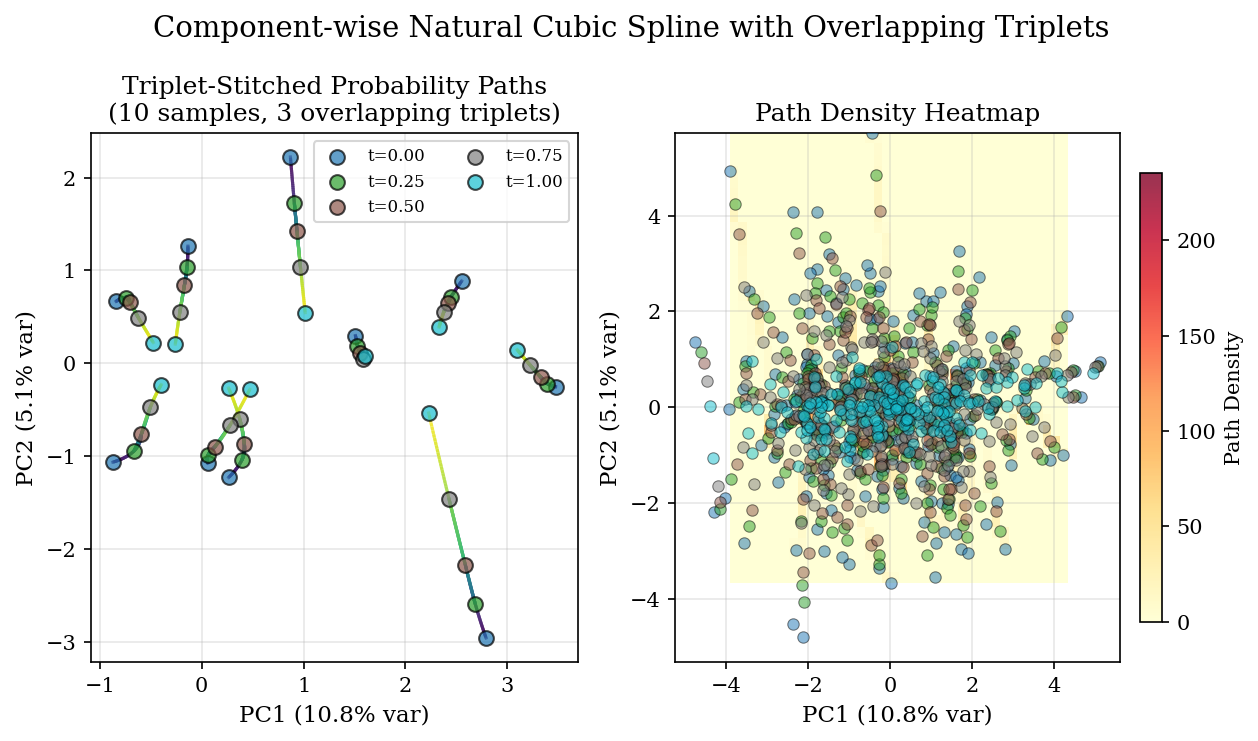


Triplet interpolated paths visualization complete!


In [17]:
print("=" * 70)
print("Triplet Interpolated Probability Paths Visualization")
print("=" * 70)
print("Showing overlapping triplet interpolation in 2D PCA space")
print(f"Using progression marginals at times: {zt_values}")
print(f"Creating {len(progression_tensors) - 2} overlapping triplets")

# Determine spline type from config (default to 'pchip')
spline_type = config.get('spline', 'pchip')
print(f"Spline type: {spline_type}")

# Use overlapping triplet approach - matches TripletAgent._get_batch from modelagent.py
# progression_tensors contains marginals at all time points
plot_interpolated_probability_paths(
    progression_tensors,  # Pass all marginals
    zt_values,            # Pass all time values
    n_samples=min(10, n_infer),
    n_eval_points=50,
    spline_type=spline_type,
    outdir=outdir,
    run=local_run,
)
display_artifact(f"interpolated_paths_triplet_{spline_type}.png")

print("\n" + "=" * 70)
print("Triplet interpolated paths visualization complete!")
print("=" * 70)

# 8. Plot Training Curves and Learning Rates
Load the logged numpy arrays to recreate training losses and learning-rate schedules for quick inspection.

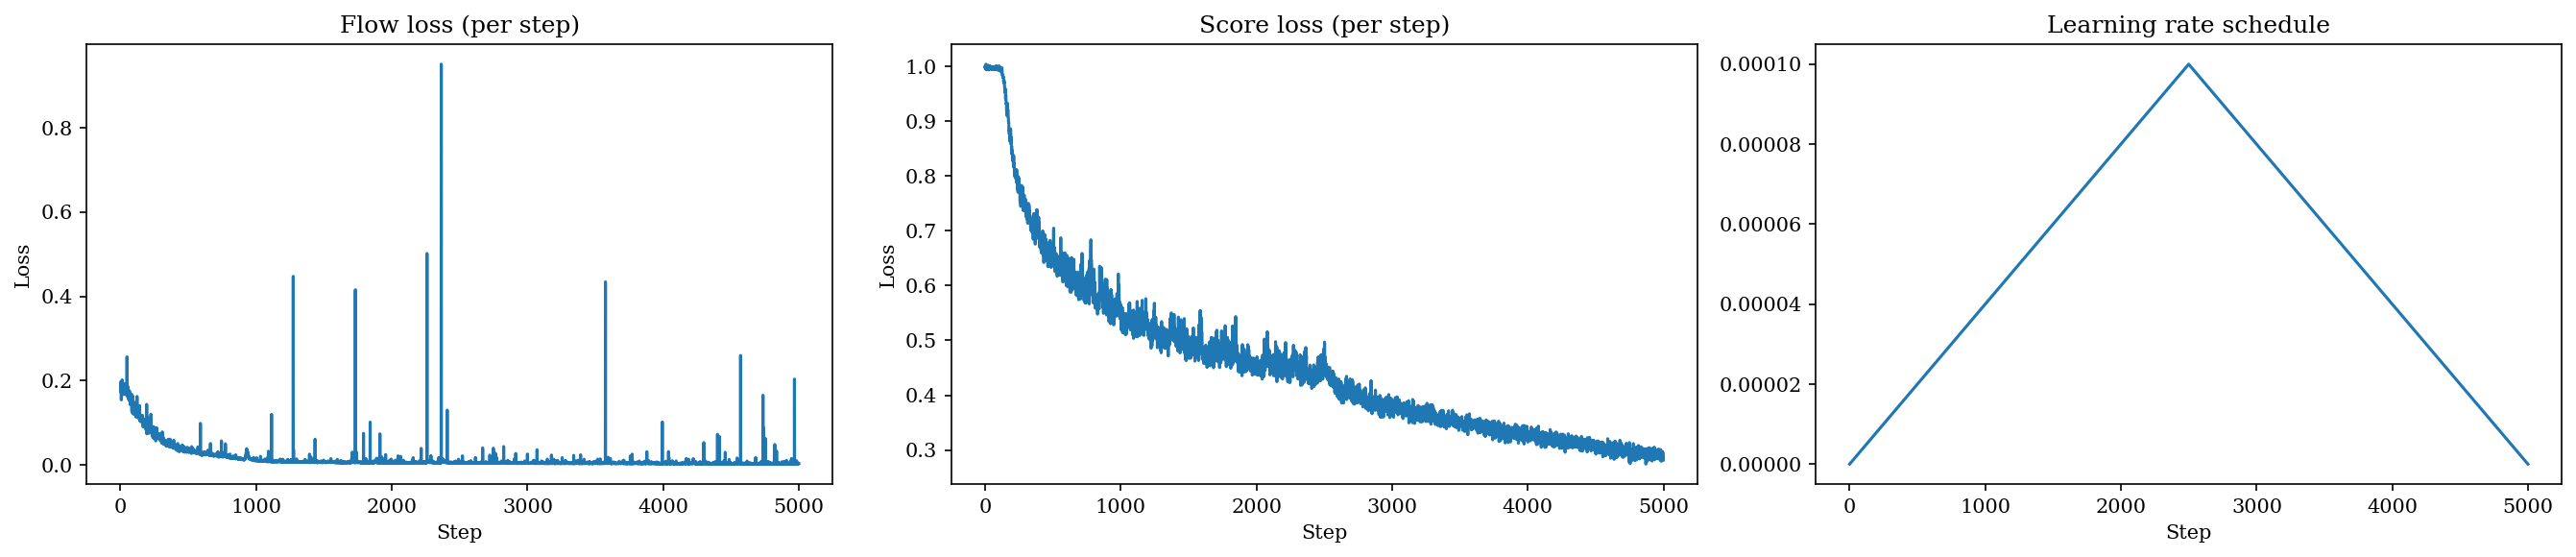

In [18]:
flow_loss_path = RESULT_DIR / "flow_losses.npy"
score_loss_path = RESULT_DIR / "score_losses.npy"
lrs_path = RESULT_DIR / "lrs.npy"

if not flow_loss_path.exists():
    print("Flow loss history not found; skipping curve plots.")
else:
    flow_losses = np.load(flow_loss_path)
    if flow_losses.ndim == 1:
        flow_losses = flow_losses[None, :]
    score_losses = None
    if score_loss_path.exists():
        score_losses = np.load(score_loss_path)
        if score_losses.ndim == 1:
            score_losses = score_losses[None, :]
    lrs = np.load(lrs_path) if lrs_path.exists() else None

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    axes[0].set_title("Flow loss (per step)")
    axes[0].plot(np.concatenate(flow_losses))
    axes[0].set_xlabel("Step")
    axes[0].set_ylabel("Loss")

    axes[1].set_title("Score loss (per step)")
    if score_losses is not None:
        axes[1].plot(np.concatenate(score_losses))
    else:
        axes[1].text(0.5, 0.5, "N/A", ha="center", va="center", fontsize=14)
    axes[1].set_xlabel("Step")
    axes[1].set_ylabel("Loss")

    axes[2].set_title("Learning rate schedule")
    if lrs is not None:
        axes[2].plot(np.concatenate(lrs))
    else:
        axes[2].text(0.5, 0.5, "N/A", ha="center", va="center", fontsize=14)
    axes[2].set_xlabel("Step")

    fig.tight_layout()
    png_path = ARTIFACT_DIR / "training_curves.png"
    fig.savefig(png_path, bbox_inches="tight", dpi=150)
    plt.close(fig)
    display(Image(filename=str(png_path)))